# Homework: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design of was heavily inspired by [Torch](http://torch.ch) which is the most convenient neural network environment when the work involves defining new layers. 

This homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- homework_modules.ipynb
- homework_differentiation.ipynb

In [5]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run homework_modules.ipynb

Optimizer is implemented for you. 

In [1]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """

    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})

    i = 0
    for cur_layer_x, cur_layer_dx in zip(x, dx):
        for cur_x, cur_dx in zip(cur_layer_x, cur_layer_dx):

            cur_old_grad = state['old_grad'].setdefault(
                i, np.zeros_like(cur_dx))

            np.add(
                config['momentum'] * cur_old_grad,
                config['learning_rate'] * cur_dx,
                out=cur_old_grad)

            cur_x -= cur_old_grad
            i += 1

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

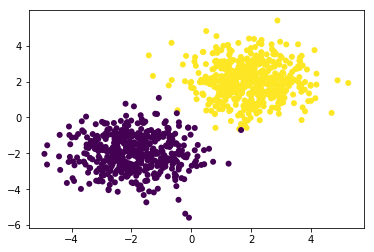

In [4]:
# Generate some data
N = 500

X1 = np.random.randn(N, 2) + np.array([2, 2])
X2 = np.random.randn(N, 2) + np.array([-2, -2])

Y = np.concatenate([np.ones(N), np.zeros(N)])[:, None]
Y = np.hstack([Y, 1 - Y])

X = np.vstack([X1, X2])
plt.scatter(X[:, 0], X[:, 1], c=Y[:, 0], edgecolors='none')

Define a **logistic regression** for debugging. 

In [5]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [6]:
# Iptimizer params
optimizer_config = {'learning_rate': 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]

    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)

        batch_idx = indices[start:end]

        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

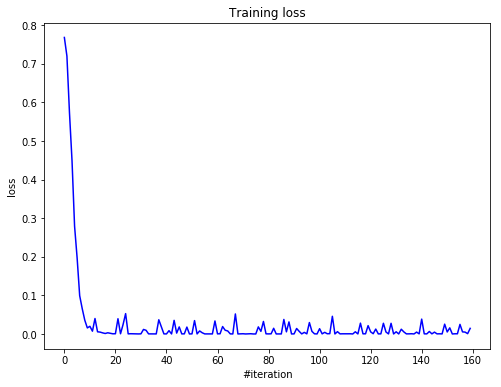

Current loss: 0.014551


In [8]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):

        net.zeroGradParameters()

        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)

        # Update weights
        sgd_momentum(net.getParameters(), net.getGradParameters(),
                     optimizer_config, optimizer_state)

        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()

    print('Current loss: %f' % loss)

# Digit classification 

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

In [3]:
import os
from sklearn.datasets import fetch_mldata

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_mldata("mnist-original")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)

One-hot encode the labels first.

In [4]:
# Your code goes here. ################################################
y = y.astype(int)
labels = np.unique(y)
Y = np.zeros((y.shape[0], len(labels)))
for i in range(len(y)):
    Y[i, y[i]] = 1
    
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33,shuffle=True)

X.shape, Y.shape

((70000, 784), (70000, 10))

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Hint: logloss for MNIST should be around 0.5. 

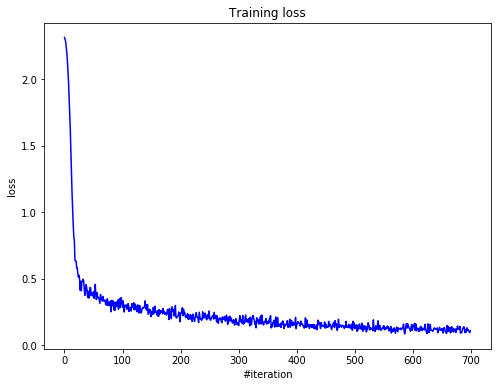

Current loss: 0.109441


In [11]:
# Your code goes here. ################################################
# Iptimizer params
optimizer_config = {'learning_rate': 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 10
batch_size = 1000

net = Sequential()
net.add(Linear(784, 40))
net.add(ReLU())
net.add(Linear(40, 10))
net.add(LogSoftMax())

loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):

        net.zeroGradParameters()

        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)

        # Update weights
        sgd_momentum(net.getParameters(), net.getGradParameters(),
                     optimizer_config, optimizer_state)

        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()

    print('Current loss: %f' % loss)

In [12]:
nonlinearities = [ReLU(), LeakyReLU(), ELU(),SoftPlus()]


def generate_net(X,
                 Y,
                 layer_size,
                 nonlinearity,
                 bn_alpha=0.2,
                 batch_norm=False):
    net = Sequential()
    _, d_out = Y.shape
    n, d_in = X.shape
    net.add(Linear(d_in, layer_size))
    if batch_norm:
        net.add(BatchNormalization(bn_alpha))
        net.add(ChannelwiseScaling(layer_size))
    net.add(nonlinearity)
    net.add(Linear(layer_size, d_out))
    net.add(LogSoftMax())
    return net


def train(net,
          X,
          Y,
          batch_sz,
          n_epoch,
          criterion=ClassNLLCriterion(),
          learning_rate=0.2,
          momentum=0.9):
    loss_history = []
    optimizer_config = {'learning_rate': learning_rate, 'momentum': momentum}
    optimizer_state = {}
    
    net.train()
    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X, Y), batch_size):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            sgd_momentum(net.getParameters(), net.getGradParameters(),
                         optimizer_config, optimizer_state)

            loss_history.append(loss)

        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))

        plt.title("Training loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history, 'b')
        plt.show()

        print('Current loss: %f' % loss)
    return loss_history

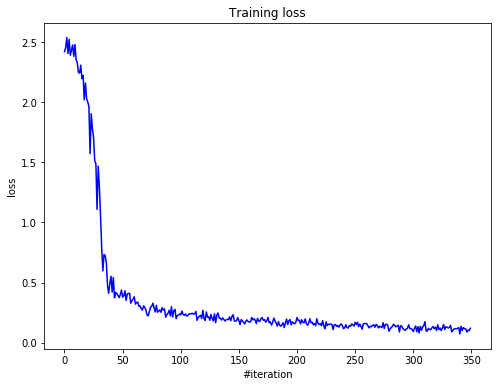

Current loss: 0.119225


In [13]:
node_size = 200
bn_alpha = 0.2
batch_size = 1000
epochs = 5

losses = []
for nll in nonlinearities:
    print("Training with ",nll)
    net = generate_net(X, Y, node_size, nll, bn_alpha, False)
    loss = train(net, X, Y, batch_size, epochs)
    bn_net = generate_net(X, Y, node_size, nll, bn_alpha, True)
    bn_loss = train(bn_net, X, Y, batch_size, epochs)
    losses.append((str(nll), loss, bn_loss))

Number of neurons in the inner layer:  200


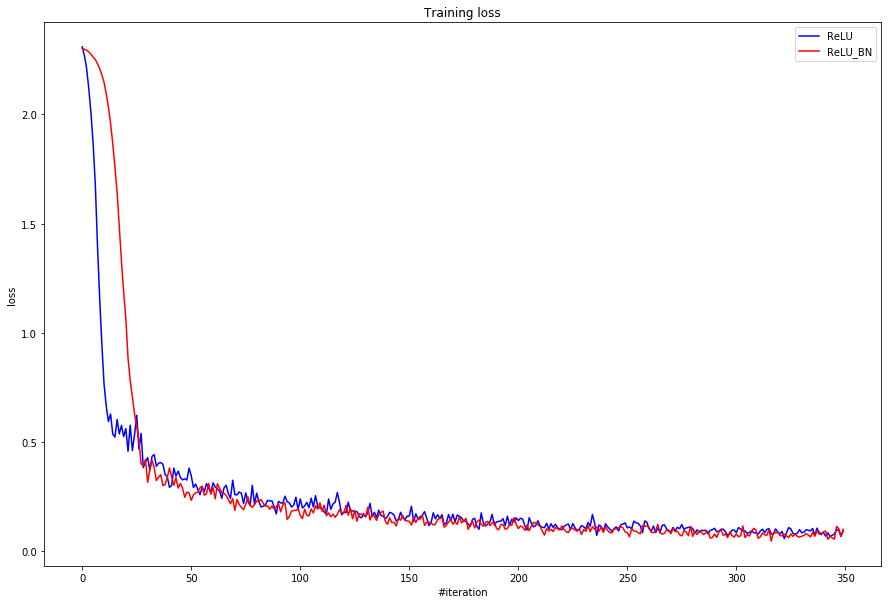

ReLU  loss:  0.05677223926790802
ReLU  loss BatchNorm :  0.04594453405421442


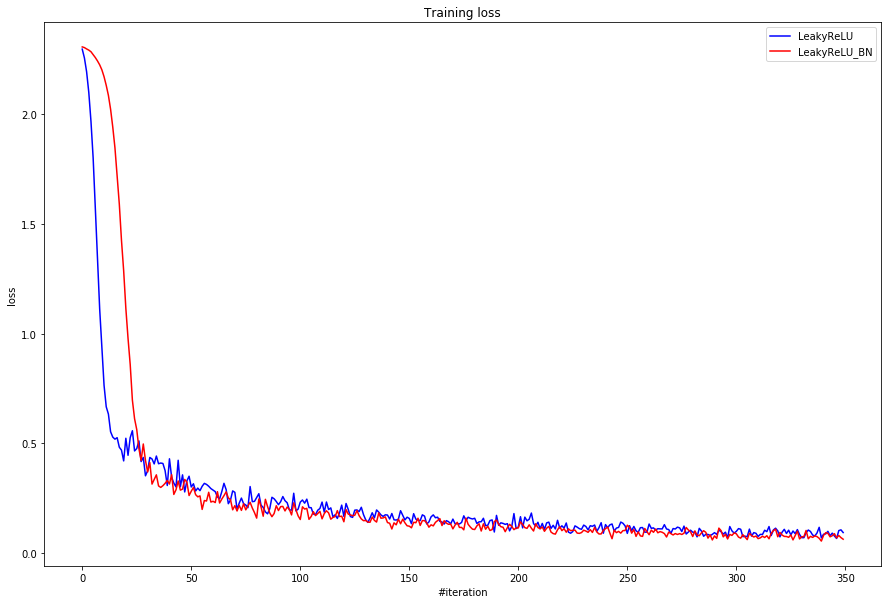

LeakyReLU  loss:  0.06782291882702295
LeakyReLU  loss BatchNorm :  0.05603968625089179


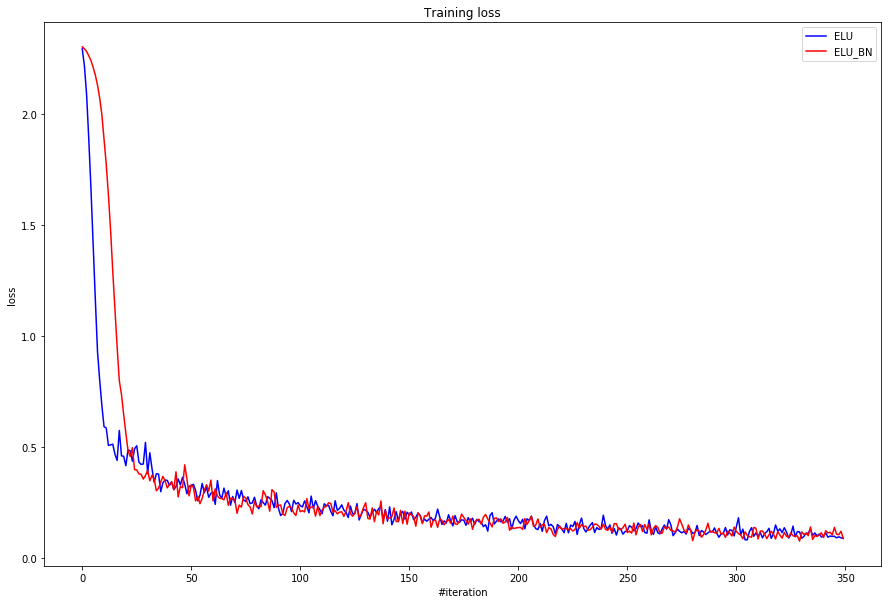

ELU  loss:  0.08407117434844667
ELU  loss BatchNorm :  0.07825298406793933


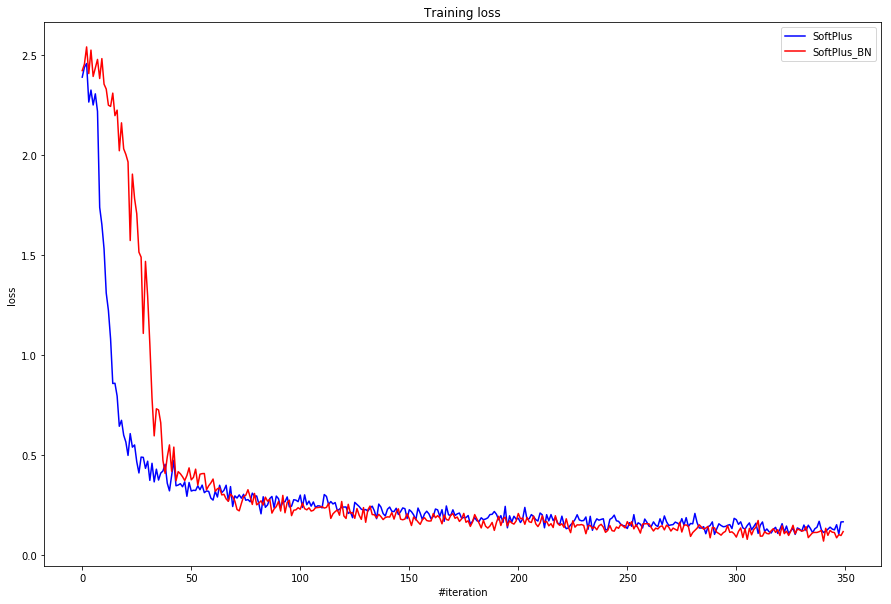

SoftPlus  loss:  0.10523291441863515
SoftPlus  loss BatchNorm :  0.07170717207450351


In [14]:
#report results
print("Number of neurons in the inner layer: ", node_size)
for (a, l, bn_l) in losses:
    # Visualize
    plt.figure(figsize=(15, 10))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    line = plt.plot(l, 'b', label=a)
    line_bn = plt.plot(bn_l, 'r', label=a + "_BN")

    plt.legend(loc="best")
    plt.show()
    
    print(a," loss: ", np.min(l))
    print(a," loss BatchNorm : ", np.min(bn_l))
    


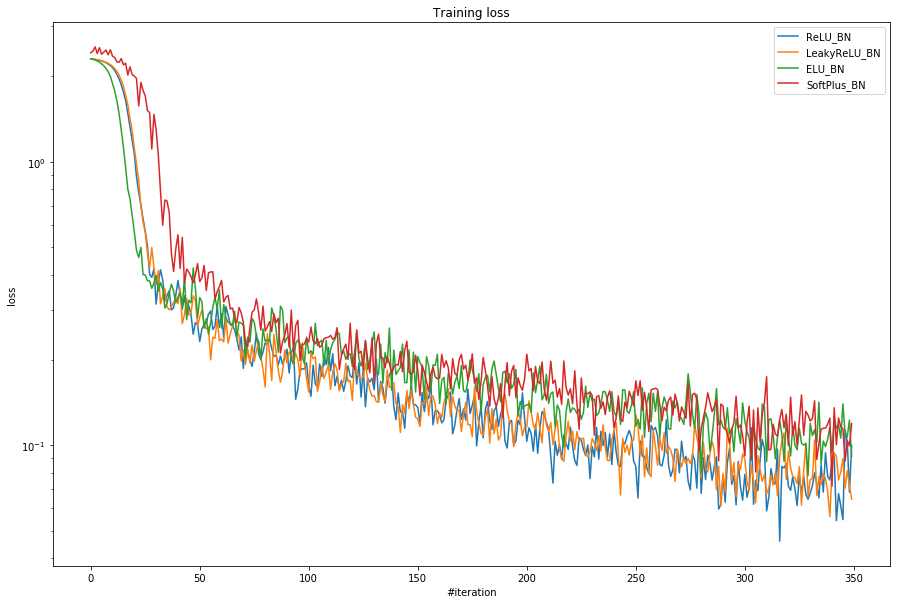

In [15]:
# compare best runs (BatchNorm) in the same plot
plt.figure(figsize=(15, 10))
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.yscale('log')

for (a, _, bn_l) in losses:    
    plt.plot(bn_l, label=a + "_BN")

plt.legend(loc="best")    
plt.show()

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

- BatchNorm yields lower loss and leads to a smoother descent (not faster, but more steady descent)
- LeakyReLU and ReLU are the best performing nonlinearities
- More nodes in the inner layer lead to smaller loss
- There exists a "smooth spot" where increasing the number of inner nodes does not give more performance. Therefore we can say that the performance is given by the available data, and not the number of neurons
- LeakyReLU benefits from more nodes
- SoftPlus does not stabilize fast when we have too many nodes

**Finally**, use all your knowledge to build a super cool model on this dataset, do not forget to split dataset into train and validation. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

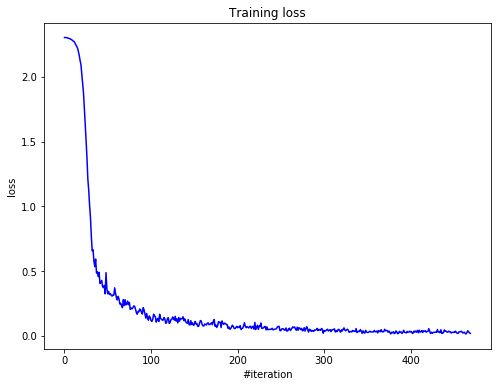

Current loss: 0.018930


In [16]:
# Your code goes here. ################################################
batch_size = 1000
epochs = 10

_, d_out = y_train.shape
_, d_in = X_train.shape
final_net = Sequential()
final_net.add(Linear(d_in, 400))
final_net.add(BatchNormalization(0.1)) # more noise here, the moving mean only gets updated with 0.1 of the batch
final_net.add(ChannelwiseScaling(400))
final_net.add(ReLU())
final_net.add(Linear(400, 200))
final_net.add(BatchNormalization(0.4)) # less noise as we approach the end so we can trust the mean more
final_net.add(ChannelwiseScaling(200))
final_net.add(LeakyReLU())
final_net.add(Dropout()) # dropout before the linear layer so we reduce computation
final_net.add(Linear(200, d_out))
final_net.add(LogSoftMax())

loss = train(final_net, X_train, y_train, batch_size, epochs)

Print here your accuracy. It should be around 90%.

In [17]:
# Your answer goes here. ################################################
from sklearn.metrics import accuracy_score
final_net.evaluate()
y_hat = final_net.forward(X_test)
final_net.train()

#y_hat is a probability distribution. Make 0-1 array
#the largest log-probability in the y_hat is the label
y_label = np.argmax(y_hat,axis=1)
# one-hot encode for comparison
y_label=np.array([y_label==i for i in range(10)]).T.astype(float)
print("the accuracy of the prediction is: ", accuracy_score(y_test,y_label))

the accuracy of the prediction is:  0.9789610389610389


# Autoencoder

Now we are going to build a cool model, named autoencoder. The aim is simple: **encode** the data to a lower dimentional representation. Why? Well, if we can **decode** this representation back to original data with "small" reconstuction loss then we can store only compressed representation saving memory. But the most important thing is -- we can reuse trained autoencoder for classification. 
<img src="autoencoder.png">

Picture from this [site](http://multithreaded.stitchfix.com/blog/2015/09/17/deep-style/).

Now implement an autoencoder:

Build it such that dimetionality inside autoencoder changes like that: 

$$784 \text{ (data)} -> 512 -> 256 -> 128 -> 30 -> 128 -> 256 -> 512 -> 784$$

Use `MSECriterion` to score the reconstruction. Use `BatchNormalization` (followed by `ChannelwiseScaling` as usual) between `Linear` and `ReLU`. You may not use nonlinearity in bottleneck layer.

You may train it for 9 epochs with batch size = 256, initial lr = 0.1 droping by a factor of 2 every 3 epochs. The reconstruction loss should be about 6.0 and visual quality decent already.
Do not spend time on changing architecture, they are more or less the same. 

In [7]:
# Your code goes here. ################################################
bn_rate=0.1
autoenc = Sequential()
autoenc.add(Linear(784, 512))
autoenc.add(BatchNormalization(bn_rate))
autoenc.add(ChannelwiseScaling(512))
# autoenc.add(LeakyReLU())

autoenc.add(Linear(512, 256))
autoenc.add(BatchNormalization(bn_rate))
autoenc.add(ChannelwiseScaling(256))
# autoenc.add(LeakyReLU())

autoenc.add(Linear(256, 128))
autoenc.add(BatchNormalization(bn_rate))
autoenc.add(ChannelwiseScaling(128))
# autoenc.add(ReLU())

autoenc.add(Linear(128, 30))
autoenc.add(BatchNormalization(bn_rate))
autoenc.add(ChannelwiseScaling(30))
# autoenc.add(ReLU()) # no activation in bottleneck

autoenc.add(Linear(30, 128))
autoenc.add(BatchNormalization(bn_rate))
autoenc.add(ChannelwiseScaling(128))
autoenc.add(ReLU())

autoenc.add(Linear(128, 256))
autoenc.add(BatchNormalization(bn_rate))
autoenc.add(ChannelwiseScaling(256))
autoenc.add(ReLU())

autoenc.add(Linear(256, 512))
autoenc.add(BatchNormalization(bn_rate))
autoenc.add(ChannelwiseScaling(512))
autoenc.add(LeakyReLU())

autoenc.add(Linear(512, 784))
autoenc.add(BatchNormalization(bn_rate))
autoenc.add(ChannelwiseScaling(784))
autoenc.add(LeakyReLU())

criterion=MSECriterion()

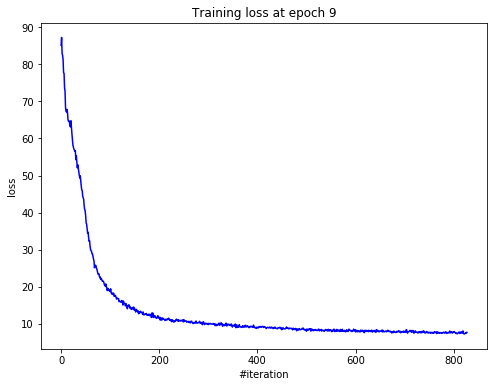

Current loss: 7.650924
Lowest training loss:  7.6509242454620034
Validation loss:  7.670276091510479


In [8]:
optimizer_config = {'learning_rate' : 0.01, 'momentum': 0.9} # recommended 0.1 is too high. Loss is too noisy
optimizer_state = {}

# Looping params
n_epoch = 9
batch_size = 512 # batch size 256 too low for fast convergence

loss_history=[]
autoenc.train()
for i in range(n_epoch):
    if (i + 1) % 3 == 0:
        optimizer_config['learning_rate'] /= 2 # decrease learning rate every 4 epochs
    for x_batch, y_batch in get_batches((X_train, X_train), batch_size):

        autoenc.zeroGradParameters()

        # Forward
        predictions = autoenc.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        autoenc.backward(x_batch, dp)

        # Update weights
        sgd_momentum(autoenc.getParameters(), autoenc.getGradParameters(),
                     optimizer_config, optimizer_state)

        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Training loss at epoch "+str(i+1))
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()

    print('Current loss: %f' % loss)
print('Lowest training loss: ', np.min(loss))

autoenc.evaluate()
n_val = 4000
X_hat = autoenc.forward(X_test[0:n_val,:])
val_loss = np.sum(np.power(X_hat - X_test[0:n_val,:],2))/n_val
print('Validation loss: ', np.min(val_loss))

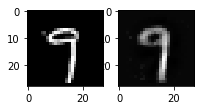

In [9]:
index = np.random.choice(range(len(X_test)))
fig = X_test[index, :].reshape(28, 28)
f , axes = plt.subplots(1, 2, figsize=(3,3))
axes[0].imshow(fig, cmap='gray')
axes[1].imshow(autoenc.forward(np.array([X_test[index, :]])).reshape(28, 28), cmap='gray')

Some time ago NNs were a lot poorer and people were struggling to learn deep models. To train a classification net people were training autoencoder first (to train autoencoder people were pretraining single layers with [RBM](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine)), then substituting the decoder part with classification layer (yeah, they were struggling with training autoencoders a lot, and complex techniques were used at that dark times). We are going to this now, fast and easy.  

In [10]:
# Extract inner representation for train and validation,
# you should get (n_samples, 30) matrices
# Your code goes here. ################################################
from IPython.core.debugger import set_trace
from copy import deepcopy
def chop_until(net,layer_name):
    decoder = deepcopy(autoenc)
    out_layer = str(decoder.modules[-1])
    while out_layer != layer_name:
#         print("Removed", out_layer)
        decoder.modules.pop()
        out_layer = str(decoder.modules[-1])
    return decoder
#     set_trace()


In [11]:
decoder = chop_until(autoenc, "ChannelwiseScaling (30)")
n_val=10000
X_train_30 = np.array([]).reshape(0,30)
Y_train_30 = np.array([]).reshape(0,10)
for x_batch, y_batch in get_batches((X_train, y_train), n_val):
    xhats = decoder.forward(x_batch)
    X_train_30 = np.vstack([X_train_30,xhats])
#     set_trace()
    Y_train_30 = np.vstack([Y_train_30,y_batch])
X_train_30.shape, Y_train_30.shape

((46900, 30), (46900, 10))

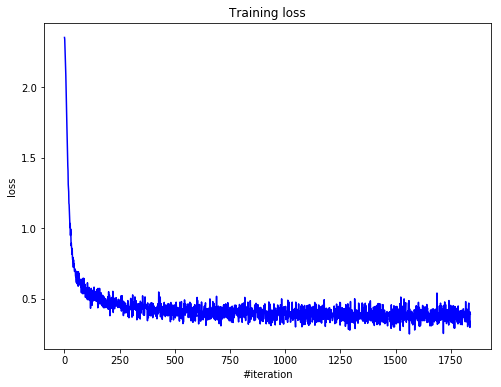

Current loss: 0.390517
Adding learned layers to the decoder


In [13]:
# Now build a logistic regression or small classification net
cnet = Sequential()
cnet.add(Linear(30, 10))
cnet.add(LogSoftMax())

loss_hist = []

# Learn the weights
# Your code goes here. ################################################
loss_hist += train(cnet, X_train_30, Y_train_30, batch_sz=1000, n_epoch=20)

# Now chop off decoder part
# (you may need to implement `remove` method for Sequential container)
# Your code goes here. ################################################
decoder = chop_until(autoenc, "ChannelwiseScaling (30)")

# And add learned layers ontop.
out_layer = str(decoder.modules[-1])
if out_layer == "ChannelwiseScaling (30)":
    print("Adding learned layers to the decoder")
    decoder.add(cnet[0])
    decoder.add(cnet[1])

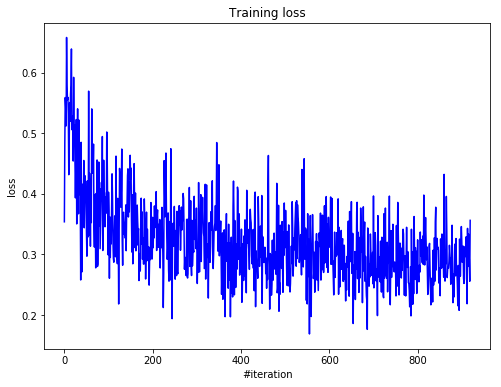

No handles with labels found to put in legend.


Current loss: 0.356097


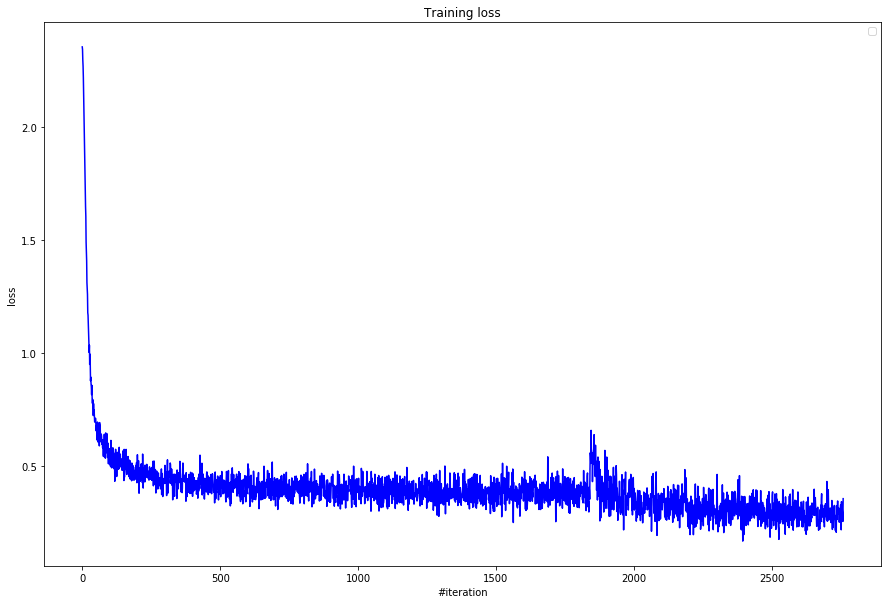

Lowest loss was:  0.16862708702173285


In [14]:

# Now optimize whole model
# Your code goes here. ################################################
loss_hist += train(decoder, X_train, y_train, batch_sz=256, n_epoch=10,criterion=ClassNLLCriterion(),
          learning_rate=0.2,
          momentum=0.9)

# Visualize
plt.figure(figsize=(15, 10))
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
line = plt.plot(loss_hist, 'b')

plt.legend(loc="best")
plt.show()

print("Lowest loss was: ",np.min(loss_hist))

* What do you think, does it make sense to build real-world classifiers this way ? Did it work better for you than a straightforward one? Looks like it was not the same ~8 years ago, what has changed beside computational power? 

- This technique is useful in transfer learning. It splits the learning task into feature extraction and classification
- It is more complicated to train this way, but it could lead to the same results as the first approach

Run PCA with 30 components on the *train set*, plot original image, autoencoder and PCA reconstructions side by side for 10 samples from *validation set*.
Probably you need to use the following snippet to make aoutpencoder examples look comparible.

In [29]:
# np.clip(prediction,0,1)
#
# Your code goes here. ################################################
from sklearn.decomposition import PCA

pca = PCA(n_components=30)
pca.fit(X_train)


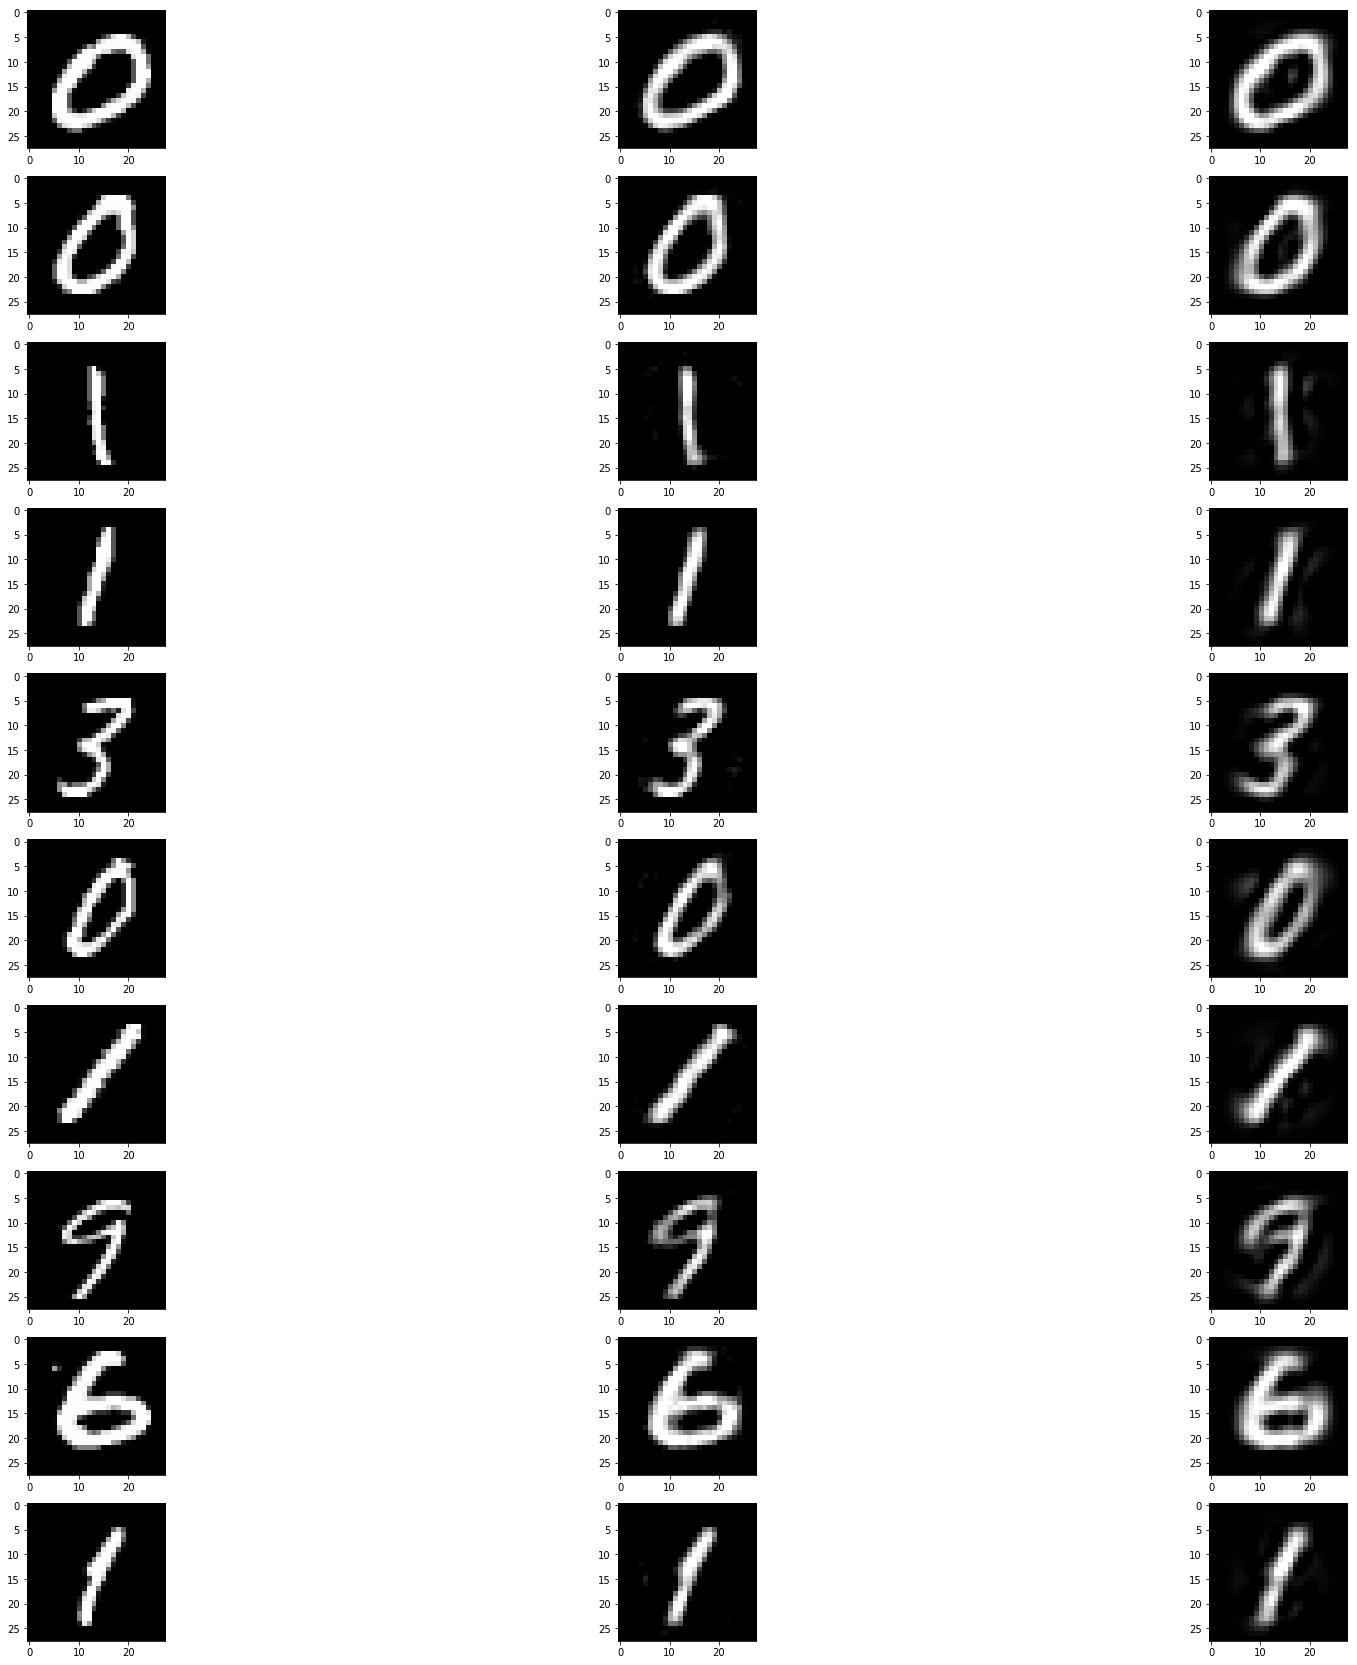

In [33]:
val_inds = np.random.choice(np.arange(X_test.shape[0]),10)
X_val = X_test[val_inds,:]
X_pca = pca.transform(X_val)
X_pca_reconstruct = pca.inverse_transform(X_pca)
autoenc.evaluate()
X_autoenc = autoenc.forward(X_val)

plt.subplots(10,3,figsize=(30,30))
for index in range(10):
    i_orig=X_test[val_inds[index],:]
    i_autoenc=X_autoenc[index,:]
    i_pca=X_pca_reconstruct[index,:]
    plt.subplot(10, 3, index*3+1)
    plt.imshow(i_orig.reshape(28,28), cmap='gray')
    
    plt.subplot(10, 3, index*3+2)
    plt.imshow(np.clip(i_autoenc,0,1).reshape(28,28), cmap='gray')
    
    plt.subplot(10, 3, index*3+3)
    plt.imshow(np.clip(i_pca,0,1).reshape(28,28), cmap='gray')
